# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Problem Statement

In this project I will determine how likely is a customer to complete an offer. The end goal is:
1. To determine, does sending more offers lead to a higher completion rate.
2. Customers with lower completion rate should be sent offers or not

## Exploratory Data Analysis

### Read Data Files

In [1]:
#######Run This
import pandas as pd
import numpy as np
import math
import json
import os
%matplotlib inline

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
profile.gender.isnull().sum()

2175

### Save The Data Files 

In [3]:
if not os.path.isdir('explore'):
    os.makedirs('explore')
    
def data_info(data, filename):
    path = os.path.join('explore', filename)
    if not os.path.isfile(path):
        pd.DataFrame(data).to_csv(path)
    print(data.shape)

data_info(portfolio, 'portfolio.csv')
data_info(profile, 'profile.csv')
data_info(transcript, 'transcript.csv')

(10, 6)
(17000, 5)
(306534, 4)


### Clean Portfolio
By looking at the portfolio file we can see that the channels column in grouped, so we'll use sklearn's MultiLabelBinarizer to unpack the channel column and then remove it from the DataFrame

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

cleaned_portfolio = portfolio.copy()
cleaned_portfolio.rename(columns={'id':'offer_id'}, inplace=True)

s = cleaned_portfolio['channels']
mlb = MultiLabelBinarizer()
channels = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=cleaned_portfolio.index)

cleaned_portfolio = cleaned_portfolio.join(channels)
cleaned_portfolio.drop(['channels'], axis=1, inplace=True)
cleaned_portfolio


,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


### Clean Profile
By looking at the profile data we can see that there are users of age 118 which mostly do not exist, we also observe that the people of age 118 have missing income values. Therefore for now we'll remove all the rows with NaN values(~2000), deduce inference and then later combine with missing values and compare results


In [5]:
#profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.rename(columns={"id":"person"}, inplace=True)
undefined_group = None
cleaned_profile = None

#cleaning profile and dividing it into cleaned_profile and undefined_group
undefined_group = profile.copy()
undefined_group['gender'] = undefined_group['gender'].fillna('U')
undefined_group = undefined_group.loc[undefined_group['gender'] == 'U'].reset_index(drop=True)
cleaned_profile = profile.dropna().reset_index(drop=True)
cleaned_profile

,gender,age,person,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


### Clean Transcript
From the transcript we can see that the column values has 2 values i.e it has an offer id or amount spent for that transaction, we'll split the value in 2 columns offer_id, amount and then drop the value column

In [6]:
cleaned_transcript = transcript.copy()
value = cleaned_transcript['value']
cleaned_transcript['amount'] = [int(i['amount']) if i.get('amount') else 0 for i in value]

cleaned_transcript['offer_id'] = [i['offer_id'] if i.get('offer_id') else (i['offer id'] if i.get('offer id') else '0') for i in value]

cleaned_transcript.drop(['value'], axis=1, inplace=True)

#drop the profile which have no gender or income
cleaned_transcript = cleaned_transcript[~cleaned_transcript.person.isin(undefined_group.person)]

sort_df = cleaned_transcript.sort_values(by=['person', 'time'])
sort_df

,person,event,time,amount,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,0,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,0,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22,0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,0,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,0,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14,0
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,0,2906b810c7d4411798c6938adc9daaa5
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,0,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10,0


### Get Data

method: get_valid_data

params: df {df is the set of all the events for a person, lets say offer received, viewed or completed}

---- The idea is to parse a set of transaction entries for a person and then divide it into offer received, offer viewed and offer completed

---- Then create a new column ['g'] which stores the cumalative count for every entry lets say offer id 'a' offered twice then the corresponding g column will store the count something like this:

    offer_id   g
        a      0
        a      1
The idea behind g is that it will help us merge elements on [person, offer_id] and will prevent duplicates

In [7]:
def get_valid_data(df):
        
    offer_received = df.loc[df['event'] == 'offer received'].reset_index(drop=True)
    offer_viewed = df.loc[df['event'] == 'offer viewed'].reset_index(drop=True)
    offer_completed = df.loc[df['event'] == 'offer completed'].reset_index(drop=True)


    offer_received['g'] = offer_received.groupby('offer_id').cumcount()
    offer_viewed['g'] = offer_viewed.groupby('offer_id').cumcount()
    offer_completed['g'] = offer_completed.groupby('offer_id').cumcount()
        

    res = pd.merge(offer_received, offer_viewed, on=['person', 'offer_id', 'g'], how='outer')
    res = pd.merge(res, offer_completed, on=['person', 'offer_id', 'g'], how='outer')

        
    return res

offers_completed = sort_df.groupby('person').apply(lambda x: get_valid_data(x))
offers_completed = offers_completed.dropna()
offers_completed = offers_completed.reset_index(drop=True)
offers_completed

,person,event_x,time_x,amount_x,offer_id,g,event_y,time_y,amount_y,event,time,amount
0,0009655768c64bdeb2e877511632db8f,offer received,408,0,f19421c1d4aa40978ebb69ca19b0e20d,0,offer viewed,456.0,0.0,offer completed,414.0,0.0
1,0009655768c64bdeb2e877511632db8f,offer received,504,0,fafdcd668e3743c1bb461111dcafc2a4,0,offer viewed,540.0,0.0,offer completed,528.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,offer viewed,186.0,0.0,offer completed,252.0,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,432.0,0.0,offer completed,576.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,offer received,504,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,516.0,0.0,offer completed,576.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
26916,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,174.0,0.0,offer completed,198.0,0.0
26917,ffff82501cea40309d5fdd7edcca4a07,offer received,336,0,2906b810c7d4411798c6938adc9daaa5,0,offer viewed,354.0,0.0,offer completed,384.0,0.0
26918,ffff82501cea40309d5fdd7edcca4a07,offer received,408,0,2906b810c7d4411798c6938adc9daaa5,1,offer viewed,414.0,0.0,offer completed,414.0,0.0
26919,ffff82501cea40309d5fdd7edcca4a07,offer received,504,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,534.0,0.0,offer completed,504.0,0.0


### Combine Portfolio with the offers completed for every entry 

method: valid_offer_completed
parameter: df {offers completed}, cleaned_portfolio {cleaned_portfolio- information about every customer like age, income}

##### Functions
1. Drop columns like amount_x, amount_y since they only have value 0 and theh drop event like offer received etc
2. Merge cleaned_portfolio[offer_type, duration] to df on offer_id 
3. Drop the columns where a user have completed and offer before and viewed it later i.e keep only those where time_y <= time 

In [8]:
def valid_offer_completed(df, cleaned_portfolio):
    df = df.rename(columns={"offer_id_x":"offer_id"})
    offers = cleaned_portfolio[['offer_id', 'offer_type', 'duration']]
    df = df.merge(offers,how='left', on='offer_id')
    
    
    df = df.drop(['amount_x', 'amount_y', 'amount', 'event_x', 'event_y', 'event', 'g'], axis=1).reset_index(drop=True)
    df = df[['person','offer_id','time_x','time_y', 'time', 'offer_type', 'duration']]
    
    df = df[(df.time_x <= df.time_y) & (df.time_y <= df.time)]
    return df

valid = valid_offer_completed(offers_completed, cleaned_portfolio)
valid = valid.reset_index(drop=True)
valid

,person,offer_id,time_x,time_y,time,offer_type,duration
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,discount,7
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,576.0,discount,10
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,576.0,bogo,7
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,54.0,discount,10
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408,426.0,510.0,bogo,5
...,...,...,...,...,...,...,...
22599,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,408,510.0,516.0,bogo,5
22600,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,0,6.0,60.0,discount,10
22601,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,174.0,198.0,discount,10
22602,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0,384.0,discount,7


### Find Informational Offers

Informational offers do not have any offer completed record so we need to find the offer_completed time because we need to combine then with the valid dataframe later on

so we'll caluate the offfer completed based on the duration of the information offer 

In [9]:
def info_offer(df):

    offer_received = df.loc[df['event'] == 'offer received'].reset_index(drop=True)
    offer_viewed = df.loc[df['event'] == 'offer viewed'].reset_index(drop=True)


    offer_received['g'] = offer_received.groupby('offer_id').cumcount()
    offer_viewed['g'] = offer_viewed.groupby('offer_id').cumcount()
        

    res = pd.merge(offer_received, offer_viewed, on=['person', 'offer_id', 'g'], how='outer')
    
    offers = cleaned_portfolio[['offer_id', 'offer_type', 'duration']]
    res = res.merge(offers,how='left', on='offer_id')
    
    res['time'] = res['time_x'] + res['duration'] * 24
    res = res.dropna()
    
    res = res[res.time_x <= res.time_y]
    res['response'] = np.where(res.time_y > res.time , 0, 1)
    res = res.loc[res.response == 1]
    
    
    res = res.drop(['response', 'amount_x', 'amount_y', 'event_x', 'event_y', 'g'], axis=1).reset_index(drop=True)
    res = res[['person','offer_id','time_x','time_y', 'time', 'offer_type', 'duration']]
    
        
    
    return res

info_df = sort_df[sort_df['offer_id'].isin(['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837'])]
info_data = info_df.groupby('person').apply(lambda x: info_offer(x))
info_data =info_data.reset_index(drop=True)
info_data

,person,offer_id,time_x,time_y,time,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,240,informational,3
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,432,informational,4
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,96,informational,4
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0,408,informational,3
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,408,408.0,480,informational,3
...,...,...,...,...,...,...,...
8347,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,336,342.0,432,informational,4
8348,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,168,198.0,240,informational,3
8349,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,408,420.0,480,informational,3
8350,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,576,636.0,672,informational,4


### Combine the valid and information dataframes

In [10]:
complete = pd.concat([valid, info_data], ignore_index=True, sort=False)
complete

,person,offer_id,time_x,time_y,time,offer_type,duration
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,discount,7
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,576.0,discount,10
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,576.0,bogo,7
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,54.0,discount,10
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408,426.0,510.0,bogo,5
...,...,...,...,...,...,...,...
30951,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,336,342.0,432.0,informational,4
30952,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,168,198.0,240.0,informational,3
30953,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,408,420.0,480.0,informational,3
30954,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,576,636.0,672.0,informational,4


### Fill Profile 
method: fill_profile
params: gd {Grouped data is the grouped data which includes all the transction record per person}, df {df is the customer portfolio}

1. Find the number of valid offers completed
2. Append the total offers completed for every person in th customer portfolio

In [11]:
df = None
def fill_profile(gd, df):
    grouped_data = gd.groupby(['person'])
    
    invalid = []
    for index, row in df.iterrows():
        if row['person'] in grouped_data.groups.keys():
            offers = grouped_data.get_group(row['person'])['offer_type'].value_counts()
            df.at[index, 'offers completed'] = offers.sum()
    
            for offer, count in offers.items():
                df.at[index, offer] = count
                
        else:
            invalid.append(row['person'])
    print(len(invalid))
    df = df.fillna(0)
    return df

In [12]:
df = fill_profile(complete, cleaned_profile)
df

2133


,gender,age,person,became_member_on,income,offers completed,bogo,informational,discount
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0.0,0.0,0.0,0.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3.0,2.0,1.0,0.0
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2.0,1.0,0.0,1.0
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5.0,3.0,0.0,2.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1.0,0.0,1.0,0.0
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1.0,0.0,1.0,0.0
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1.0,0.0,1.0,0.0
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1.0,1.0,0.0,0.0


### Find Data

method: find_data
parameters: gd {gd is the grouped data which includes all the transction record per person}, df {df is the customer portfolio}

1. Find the total number of offers received for every customer from the original transcript not the updated one
2. Calculate the completion rate
3. Append the new details in the customer portfiolio dataframe for each user

In [13]:
def find_data(gd, df):
    gd = gd[(gd.event == 'offer received')].reset_index(drop=True)
    grouped_data = gd.groupby(['person'])

    
    for index, row in df.iterrows():
        if row['person'] in grouped_data.groups.keys():
            events = grouped_data.get_group(row['person'])['event'].count()
            df.at[index, 'offers received'] = events
            df.at[index, 'completion rate'] = row['offers completed'] * 100 / events
            
    return df

In [14]:
df = find_data(sort_df, df)
df

,gender,age,person,became_member_on,income,offers completed,bogo,informational,discount,offers received,completion rate
0,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0.0,0.0,0.0,0.0,2.0,0.000000
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3.0,2.0,1.0,0.0,4.0,75.000000
2,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2.0,1.0,0.0,1.0,4.0,50.000000
3,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5.0,3.0,0.0,2.0,6.0,83.333333
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1.0,0.0,0.0,1.0,3.0,33.333333
...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1.0,0.0,1.0,0.0,3.0,33.333333
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1.0,0.0,1.0,0.0,3.0,33.333333
14822,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1.0,0.0,1.0,0.0,3.0,33.333333
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1.0,1.0,0.0,0.0,3.0,33.333333


### Find amount
1. Find the total amount spent by each user

In [15]:
def find_amount(df):
    amount = pd.DataFrame()
    values = df.groupby(['person']).sum()
    amount['person'] = values.index
    amount['total amount'] = values.amount.to_numpy()
    return amount
    

total_amount = find_amount(cleaned_transcript)
df = df.merge(total_amount, on='person')
df = df.reset_index(drop=True)

########### Convert gender to M-0/F-1/O-2
df['gender'] = df['gender'].map({'M': 0, 'F': 1, 'O': 2})
df = df.fillna(0)
df

,gender,age,person,became_member_on,income,offers completed,bogo,informational,discount,offers received,completion rate,total amount
0,1,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0.0,0.0,0.0,0.0,2.0,0.000000,76
1,1,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3.0,2.0,1.0,0.0,4.0,75.000000,154
2,0,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,2.0,1.0,0.0,1.0,4.0,50.000000,56
3,0,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,5.0,3.0,0.0,2.0,6.0,83.333333,35
4,0,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,1.0,0.0,0.0,1.0,3.0,33.333333,14
...,...,...,...,...,...,...,...,...,...,...,...,...
14820,1,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1.0,0.0,1.0,0.0,3.0,33.333333,16
14821,0,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1.0,0.0,1.0,0.0,3.0,33.333333,22
14822,0,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1.0,0.0,1.0,0.0,3.0,33.333333,36
14823,1,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1.0,1.0,0.0,0.0,3.0,33.333333,184


In [16]:
data_info(df, 'complete_profile_with_missing_values.csv')
data_info(complete, 'transcript_with_missing_values.csv')

(14825, 12)
(30956, 7)


# Data Visualization

### Visualising the Data in 1D Space

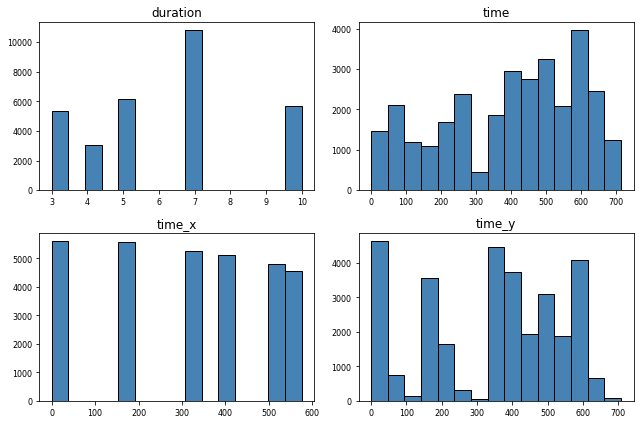

In [17]:
import matplotlib.pyplot as plt
import matplotlib

complete.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

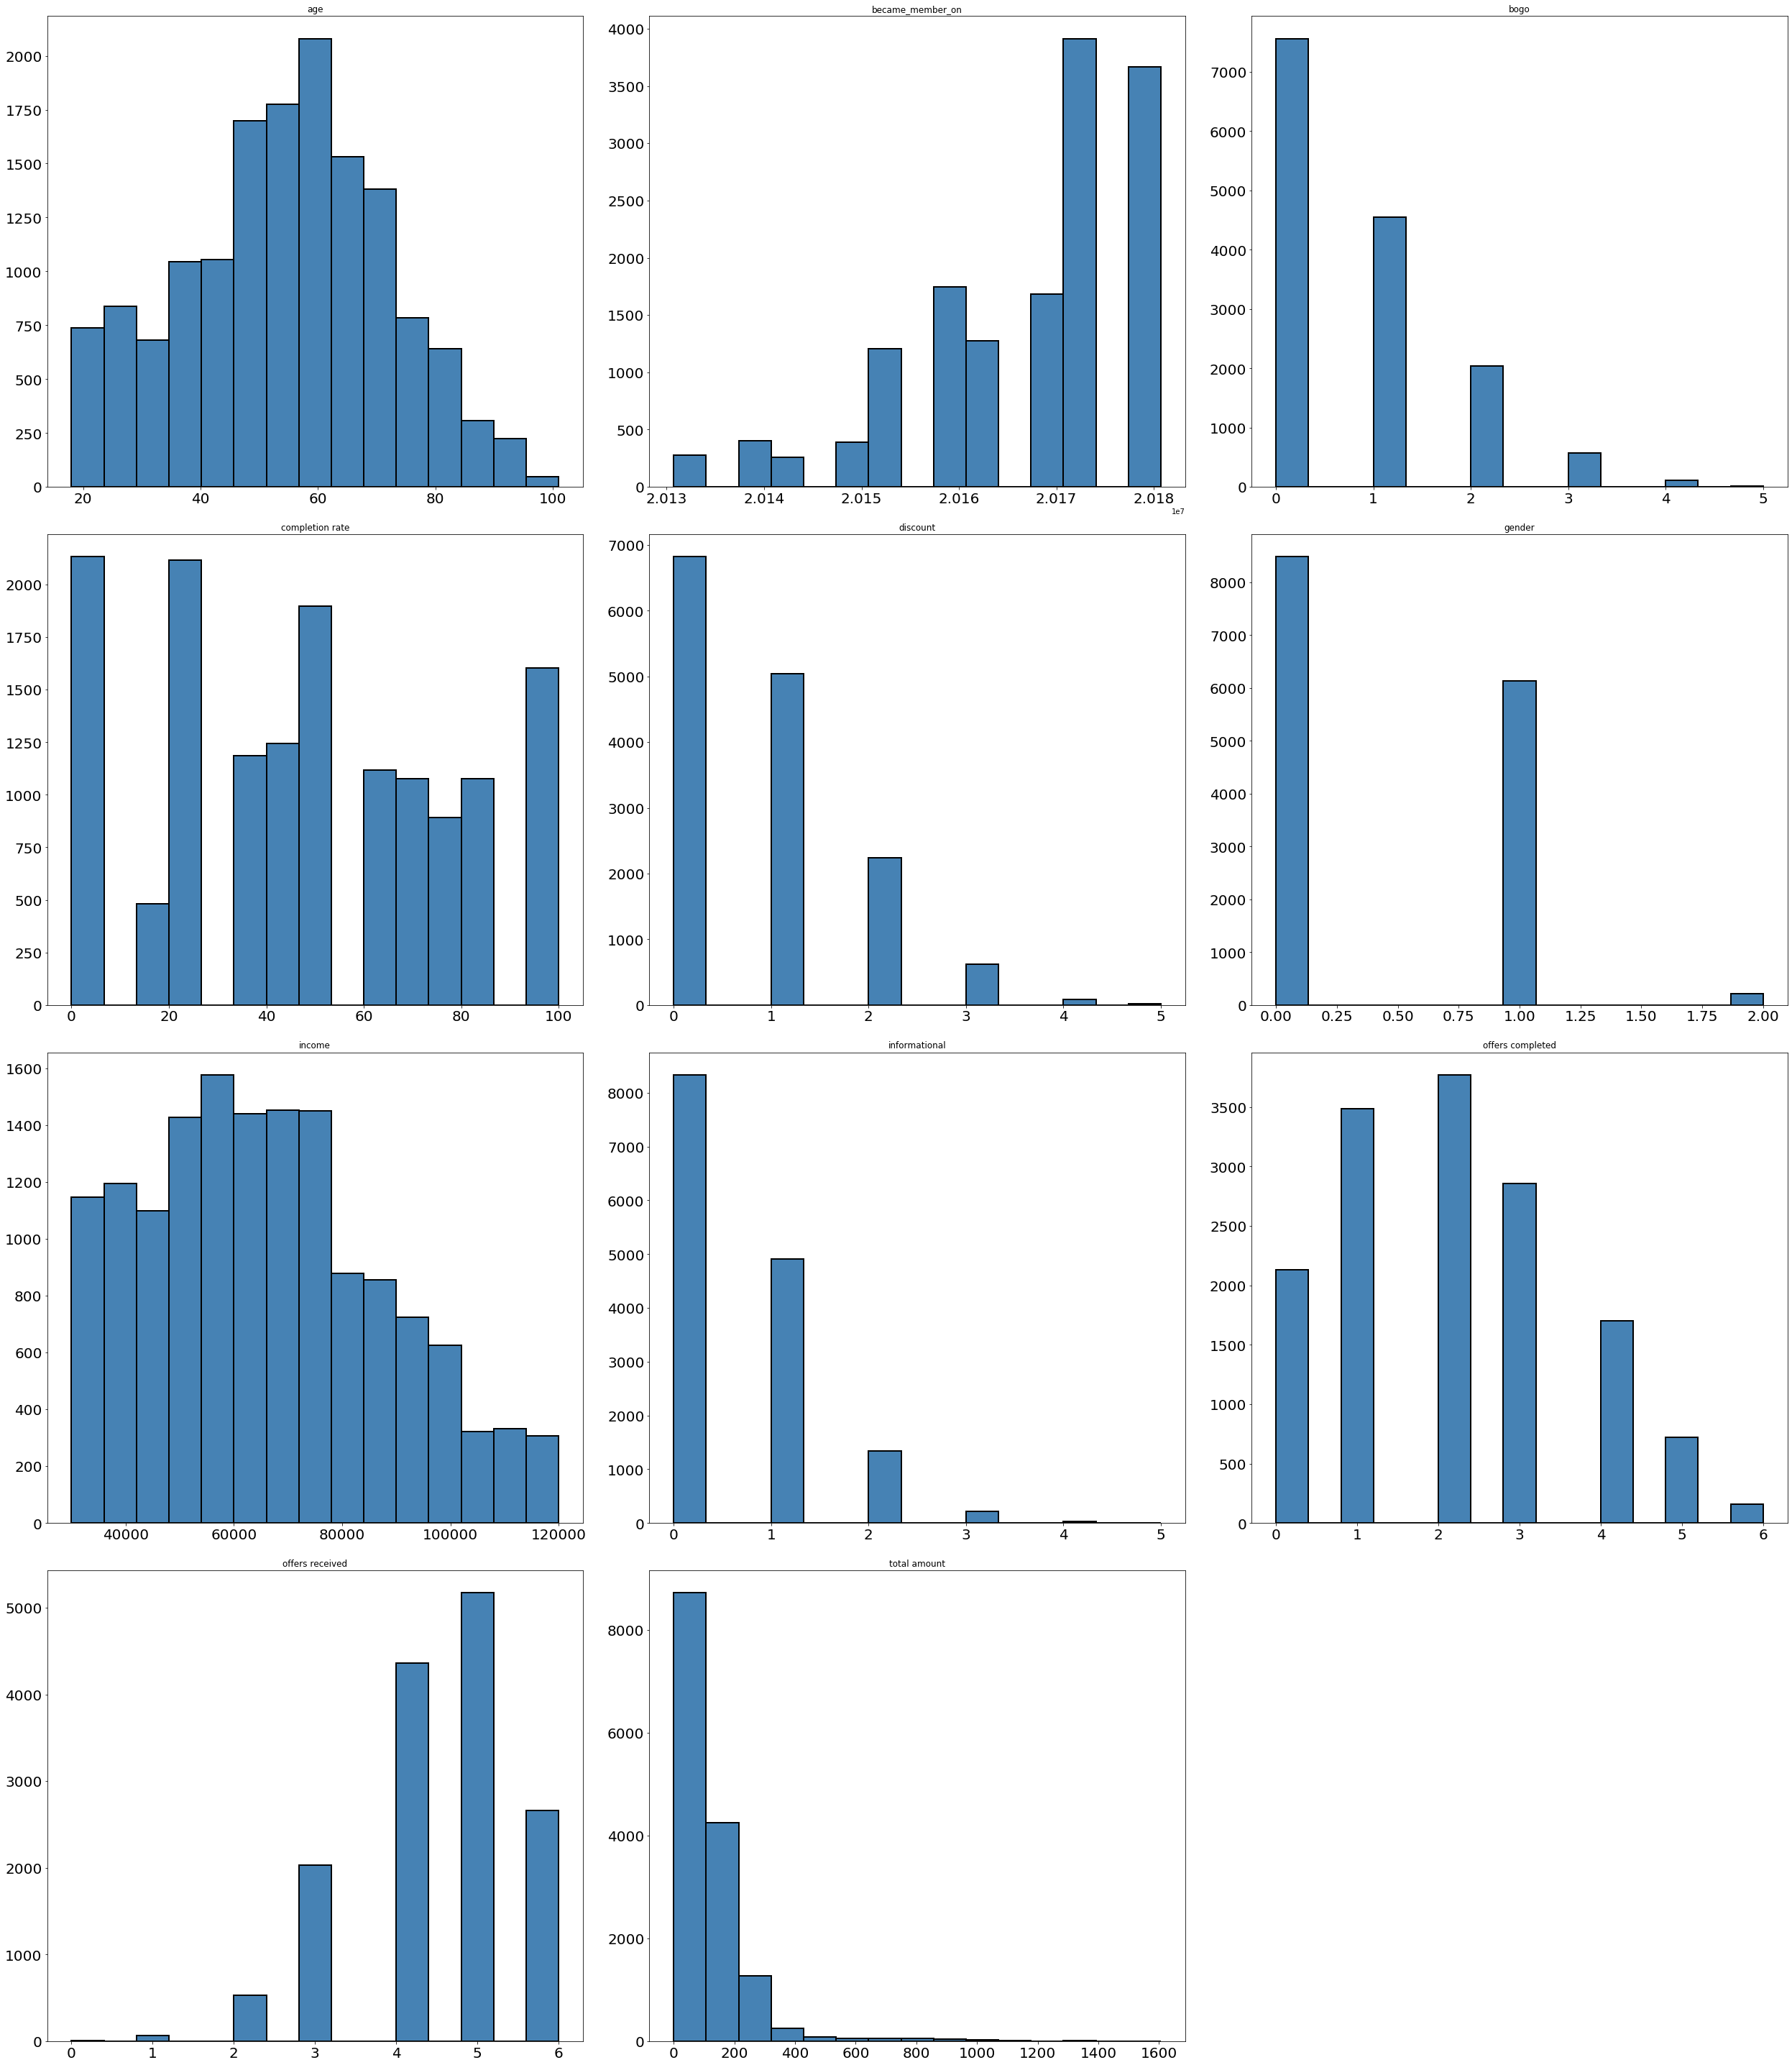

In [18]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=2.0,
           xlabelsize=20, ylabelsize=20, grid=False)    
plt.tight_layout(rect=(0, 0, 5.8, 10))

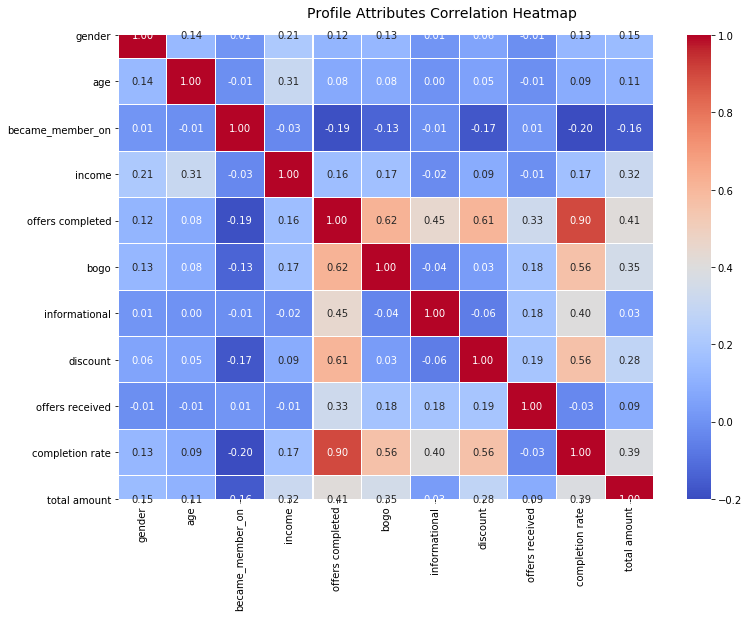

In [19]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
corr = df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Profile Attributes Correlation Heatmap', fontsize=14)

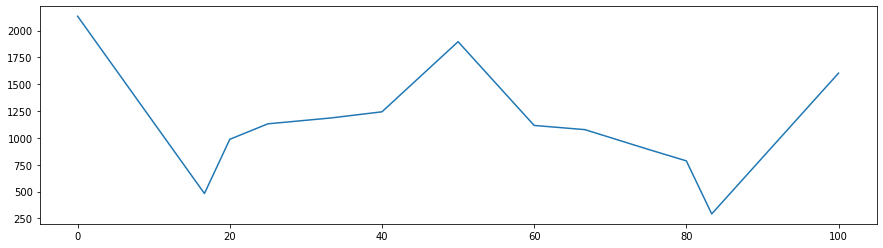

In [20]:
plt.figure(figsize=(15,4))
plt.plot(df['completion rate'].value_counts().sort_index())

# Unsupervised Learning

We will use 2 unsuoervised learning algorithms to check if our data is actually seprable in approximately 5 clusters
The reason being if we get good number of clusters(4 or 5) then we can go and label all the data points according to our logic for likeliness (will be discussed later)

In [21]:
df.index = df['person']
df = df.drop(['person'], axis = 1)

###  Normalizing the data
 Using sklearn's Min Max Scaler we will normalize the data in the range of 0 to 1 so that it becomes easier to work with supervised or unsupervised algorithms  

In [22]:
from sklearn.preprocessing import MinMaxScaler

def normalize_data(df):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.astype(float)))
    df_scaled.columns = df.columns
    df_scaled.index = df.index
    
    return df_scaled

df_scaled = normalize_data(df)
df_scaled

,gender,age,became_member_on,income,offers completed,bogo,informational,discount,offers received,completion rate,total amount
person,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.5,0.445783,0.799768,0.911111,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.047323
78afa995795e4d85b5d9ceeca43f5fef,0.5,0.686747,0.795648,0.777778,0.500000,0.4,0.2,0.0,0.666667,0.750000,0.095890
e2127556f4f64592b11af22de27a7932,0.0,0.602410,0.994000,0.444444,0.333333,0.2,0.0,0.2,0.666667,0.500000,0.034869
389bc3fa690240e798340f5a15918d5c,0.0,0.566265,0.989659,0.255556,0.833333,0.6,0.0,0.4,1.000000,0.833333,0.021793
2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.481928,0.807688,0.233333,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.008717
...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.5,0.325301,0.997560,0.266667,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.009963
2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.518072,0.999740,0.466667,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.013699
01d26f638c274aa0b965d24cefe3183f,0.0,0.373494,0.787987,0.477778,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.022416


### Agglomerative Clustering
1. Plot the dendogram
2. Based on the dendogram detemine the distance threshold
3. Use the distance threshold to find the number of clusters
4. Check the distribution of clusters

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [55.0, 55.0, 65.0, 65.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [60.0, 60.0, 83.75, 83.75],
  [45.0, 45.0, 71.875, 71.875],
  [30.0, 30.0, 58.4375, 58.4375],
  [10.0, 10.0, 44.21875, 44.21875]],
 'dcoord': [[0.0, 36.25098688012404, 36.25098688012404, 0.0],
  [0.0, 32.81913141111118, 32.81913141111118, 0.0],
  [0.0, 22.056845750116572, 22.056845750116572, 0.0],
  [0.0, 20.805597664820105, 20.805597664820105, 0.0],
  [0.0, 22.460359824159415, 22.460359824159415, 20.805597664820105],
  [0.0, 23.901646072497243, 23.901646072497243, 22.460359824159415],
  [22.056845750116572,
   32.78417639993727,
   32.78417639993727,
   23.901646072497243],
  [0.0, 36.86403316937654, 36.86403316937654, 32.78417639993727],
  [32.81913141111118, 38.29965186961018, 38.29965186961018, 36.86403316937654],
  [36.25098688012404,
   50.489458747243596,
   50.489458747243596,
   38.29965186961018]]

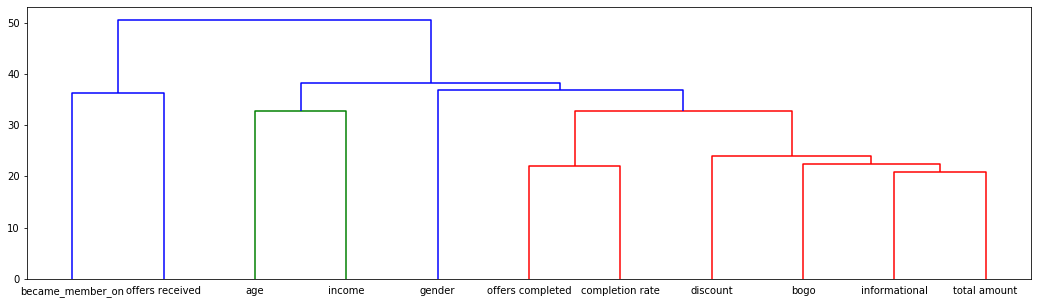

In [23]:
import matplotlib.pyplot as plt
from hcluster import pdist, linkage, dendrogram

X = df_scaled.T.values #Transpose values 
Y = pdist(X)
Z = linkage(Y)
plt.subplots(figsize=(18,5))
dendrogram(Z, labels = df_scaled.columns)

from the dendogram gram graph we cab determine the distance threshold i.e. the line from where we can cut the graph is about 40 on the y axis

In [24]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=40)
agg_clusters = np.array(cluster.fit_predict(df_scaled))

In [25]:
unique, counts = np.unique(agg_clusters, return_counts=True)
dict(zip(unique, counts))

{0: 8505, 1: 6320}

### K-means Clustering
 1. Apply kmeans and find out the optimal number of clusters using the elbow method
 2. Analyse the no of clusters formed and select the one where the clusters are equally distributed

Cluster  1 {0: 14825}
Cluster  2 {0: 7306, 1: 7519}
Cluster  3 {0: 3638, 1: 5815, 2: 5372}
Cluster  4 {0: 3323, 1: 4538, 2: 3019, 3: 3945}
Cluster  5 {0: 3097, 1: 3125, 2: 3935, 3: 2957, 4: 1711}
Cluster  6 {0: 2025, 1: 3745, 2: 1632, 3: 2832, 4: 1924, 5: 2667}
Cluster  7 {0: 2162, 1: 1894, 2: 1963, 3: 2936, 4: 2677, 5: 1857, 6: 1336}
Cluster  8 {0: 2134, 1: 1867, 2: 1853, 3: 2934, 4: 1738, 5: 1660, 6: 1387, 7: 1252}
Cluster  9 {0: 1218, 1: 1747, 2: 1362, 3: 2703, 4: 1676, 5: 1606, 6: 1778, 7: 1563, 8: 1172}


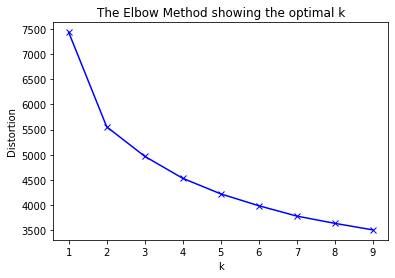

In [26]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# create new plot and data
plt.plot()
X = df_scaled

# k means determine k
distortions = []
for k in range(1,10):
    km = KMeans(n_clusters=k, n_init=30)
    km.fit(X)
    wcss = km.inertia_
    km_clusters = km.predict(X)
    unique, counts = np.unique(km_clusters, return_counts=True)
    print("Cluster ", k, dict(zip(unique, counts)))
    distortions.append(wcss)

# Plot the elbow
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

from the k-means clustering we can see that for cluster 4 and cluster 5, and also from the elbow graph we can see that around 5 clusters are suitable 

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_scaled)

labels = kmeans.predict(df_scaled)
centroids = kmeans.cluster_centers_

unique, counts = np.unique(labels, return_counts=True)
print("Cluster 5",dict(zip(unique, counts)))

Cluster 5 {0: 3115, 1: 1705, 2: 2955, 3: 3114, 4: 3936}


### Unsupervised Learning Algorithm Results
Agglomerative clustering gives really bad results because of the variability in our dataset, whereas k-means gives an average result. We can also see that the elbow graph is not well formed but we do get an idea of the separablity in our dataset. Thereforw we will now use Supervised Learning Algorithms to properly label our data

## Supervised Learning for Multi-Label Classification

### Determining the likeliness

logic of determining the likeliness is column*weight,I am determining the likeliness using offer completion rate, and the the offer types i.e. bogo, informational and discount. We assign the completion rate a weightage of 3 and offer type a weightage of 1. We noramlize the dataframe so that all the values in the 3 offer type columns are in the range and therefore the logic begind weightage can be applied. 

total weights = 3(completion rate) + 1(offer types) = 4

score  = { (bogo + informational + discount)/3 + completion_rate*3} / total_weight

Label 4 - Very Likely (score>= 80)

Label 3 - Likely (score>= 60)

Label 2 - Neutral(50% chance) (score>= 40)

Label 1 - Unlikely(score>= 20)

Label 0 - Very Unlikely (score < 20)

In [28]:
def calculate_likeliness(rate):
    if rate >= 80 and rate <= 100:
        return 4
    elif rate >= 60 and rate < 80:
        return 3
    elif rate >= 40 and rate < 60:
        return 2
    elif rate >= 20 and rate < 40:
        return 1
    else:
        return 0


def likelihood(row):
    completion_rate= row[9]
    discount = row[7]
    informational = row[6]
    bogo = row[5]
        
    
    
    rate = ((discount + informational + bogo)/3 + completion_rate*3)/4
    
    return calculate_likeliness(rate * 100)
    

df_scaled.apply(lambda x: likelihood(x), axis=1)
df_scaled['likeliness'] = df_scaled.apply(lambda x: likelihood(x), axis=1)
df_scaled


,gender,age,became_member_on,income,offers completed,bogo,informational,discount,offers received,completion rate,total amount,likeliness
person,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.5,0.445783,0.799768,0.911111,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.047323,0
78afa995795e4d85b5d9ceeca43f5fef,0.5,0.686747,0.795648,0.777778,0.500000,0.4,0.2,0.0,0.666667,0.750000,0.095890,3
e2127556f4f64592b11af22de27a7932,0.0,0.602410,0.994000,0.444444,0.333333,0.2,0.0,0.2,0.666667,0.500000,0.034869,2
389bc3fa690240e798340f5a15918d5c,0.0,0.566265,0.989659,0.255556,0.833333,0.6,0.0,0.4,1.000000,0.833333,0.021793,3
2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.481928,0.807688,0.233333,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.008717,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.5,0.325301,0.997560,0.266667,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.009963,1
2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.518072,0.999740,0.466667,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.013699,1
01d26f638c274aa0b965d24cefe3183f,0.0,0.373494,0.787987,0.477778,0.166667,0.0,0.2,0.0,0.500000,0.333333,0.022416,1


In [29]:
## we can see that the data is well distributed 
df_scaled.likeliness.value_counts()

2    3895
1    3754
0    3602
3    2174
4    1400
Name: likeliness, dtype: int64

In [30]:
# drop the columns used for determing the likeliness, so that our supervised learning model is not able to cheat
df_scaled = df_scaled.drop(['bogo', 'informational', 'discount', 'completion rate'], axis=1)
df_scaled

,gender,age,became_member_on,income,offers completed,offers received,total amount,likeliness
person,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.5,0.445783,0.799768,0.911111,0.000000,0.333333,0.047323,0
78afa995795e4d85b5d9ceeca43f5fef,0.5,0.686747,0.795648,0.777778,0.500000,0.666667,0.095890,3
e2127556f4f64592b11af22de27a7932,0.0,0.602410,0.994000,0.444444,0.333333,0.666667,0.034869,2
389bc3fa690240e798340f5a15918d5c,0.0,0.566265,0.989659,0.255556,0.833333,1.000000,0.021793,3
2eeac8d8feae4a8cad5a6af0499a211d,0.0,0.481928,0.807688,0.233333,0.166667,0.500000,0.008717,1
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.5,0.325301,0.997560,0.266667,0.166667,0.500000,0.009963,1
2cb4f97358b841b9a9773a7aa05a9d77,0.0,0.518072,0.999740,0.466667,0.166667,0.500000,0.013699,1
01d26f638c274aa0b965d24cefe3183f,0.0,0.373494,0.787987,0.477778,0.166667,0.500000,0.022416,1


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mat = df_scaled.values
mat = df_scaled.values

X = mat[:,0:7]
Y = mat[:,7]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [32]:
def find_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [33]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
# print(clf.coef_)
# print(clf.intercept_)
y_pred = clf.predict(X_test)
find_accuracy(y_test, y_pred)

Accuracy: 74.62%


In [34]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
find_accuracy(y_test, y_pred)

/Users/lokesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 97.69%


In [35]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
find_accuracy(y_test, y_pred)

/Users/lokesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 62.58%


In [36]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
find_accuracy(y_test, y_pred)

Accuracy: 96.20%


In [37]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
find_accuracy(y_test, rf_pred)

Accuracy: 99.31%


/Users/lokesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Benchmark Model
Xgboost Algorithm is our benchmark model because it performs tasks like multilabel classifcation with ease and with very High accuracy

In [38]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
find_accuracy(y_test, y_pred)

Accuracy: 100.00%


## Evaluating the Model

#### Now we will evaluate our random forest model

In [39]:
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print('Accuracy -val set: %.2f%% (%.2f)' % (results.mean()*100, results.std()))

print("MAE test score:", mean_absolute_error(y_test, rf_pred))
print("RMSE test score:", sqrt(mean_squared_error(y_test, rf_pred)))

[[1164    0    0    0    0]
 [   0 1214    0    0    0]
 [   0    0 1305    0    0]
 [   0    7   10  725    2]
 [   0    0    2   13  451]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1164
         1.0       0.99      1.00      1.00      1214
         2.0       0.99      1.00      1.00      1305
         3.0       0.98      0.97      0.98       744
         4.0       1.00      0.97      0.98       466

    accuracy                           0.99      4893
   macro avg       0.99      0.99      0.99      4893
weighted avg       0.99      0.99      0.99      4893

Accuracy -val set: 100.00% (0.00)
MAE test score: 0.008788064582055999
RMSE test score: 0.11165477728616732


In [60]:
## Evaluating XGBoost Model
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print('Accuracy -val set: %.2f%% (%.2f)' % (results.mean()*100, results.std()))

print("MAE test score:", mean_absolute_error(y_test, y_pred))
print("RMSE test score:", sqrt(mean_squared_error(y_test, y_pred)))

[[1164    0    0    0    0]
 [   0 1214    0    0    0]
 [   0    0 1305    0    0]
 [   0    0    0  744    0]
 [   0    0    0    0  466]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1164
         1.0       1.00      1.00      1.00      1214
         2.0       1.00      1.00      1.00      1305
         3.0       1.00      1.00      1.00       744
         4.0       1.00      1.00      1.00       466

    accuracy                           1.00      4893
   macro avg       1.00      1.00      1.00      4893
weighted avg       1.00      1.00      1.00      4893

Accuracy -val set: 100.00% (0.00)
MAE test score: 0.0
RMSE test score: 0.0


#### We can observe that our model performs really well and it has accuracy nearly as our benchmark model with really low MAE and RMSE Scores

## Now solving the same problem by filling the missing values

In [40]:
undefined = None
income_max = cleaned_profile.income.describe().max()
undefined_group = undefined_group.fillna(income_max)
# undefined = pd.concat([undefined_group, cleaned_profile], ignore_index=True)

# undefined
complete_transcript = transcript.copy()
value = complete_transcript['value']
complete_transcript['amount'] = [int(i['amount']) if i.get('amount') else 0 for i in value]

complete_transcript['offer_id'] = [i['offer_id'] if i.get('offer_id') else (i['offer id'] if i.get('offer id') else '0') for i in value]

complete_transcript.drop(['value'], axis=1, inplace=True)

sort_df = complete_transcript.sort_values(by=['person', 'time'])
sort_df

,person,event,time,amount,offer_id
55972,0009655768c64bdeb2e877511632db8f,offer received,168,0,5a8bc65990b245e5a138643cd4eb9837
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,0,5a8bc65990b245e5a138643cd4eb9837
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22,0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,0,3f207df678b143eea3cee63160fa8bed
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,0,3f207df678b143eea3cee63160fa8bed
...,...,...,...,...,...
258361,ffff82501cea40309d5fdd7edcca4a07,transaction,576,14,0
258362,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,0,2906b810c7d4411798c6938adc9daaa5
262475,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,0,2906b810c7d4411798c6938adc9daaa5
274809,ffff82501cea40309d5fdd7edcca4a07,transaction,606,10,0


In [41]:
users  = sort_df.groupby('person').apply(lambda x: get_valid_data(x))
users = users.dropna() 
users = users.reset_index(drop=True)
users

,person,event_x,time_x,amount_x,offer_id,g,event_y,time_y,amount_y,event,time,amount
0,0009655768c64bdeb2e877511632db8f,offer received,408,0,f19421c1d4aa40978ebb69ca19b0e20d,0,offer viewed,456.0,0.0,offer completed,414.0,0.0
1,0009655768c64bdeb2e877511632db8f,offer received,504,0,fafdcd668e3743c1bb461111dcafc2a4,0,offer viewed,540.0,0.0,offer completed,528.0,0.0
2,0011e0d4e6b944f998e987f904e8c1e5,offer received,168,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,offer viewed,186.0,0.0,offer completed,252.0,0.0
3,0011e0d4e6b944f998e987f904e8c1e5,offer received,408,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,432.0,0.0,offer completed,576.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,offer received,504,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,516.0,0.0,offer completed,576.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27945,ffff82501cea40309d5fdd7edcca4a07,offer received,168,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,offer viewed,174.0,0.0,offer completed,198.0,0.0
27946,ffff82501cea40309d5fdd7edcca4a07,offer received,336,0,2906b810c7d4411798c6938adc9daaa5,0,offer viewed,354.0,0.0,offer completed,384.0,0.0
27947,ffff82501cea40309d5fdd7edcca4a07,offer received,408,0,2906b810c7d4411798c6938adc9daaa5,1,offer viewed,414.0,0.0,offer completed,414.0,0.0
27948,ffff82501cea40309d5fdd7edcca4a07,offer received,504,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,offer viewed,534.0,0.0,offer completed,504.0,0.0


In [42]:
valid_df = valid_offer_completed(users, cleaned_portfolio)
valid_df

,person,offer_id,time_x,time_y,time,offer_type,duration
2,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,discount,7
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,576.0,discount,10
4,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,576.0,bogo,7
5,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,54.0,discount,10
6,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408,426.0,510.0,bogo,5
...,...,...,...,...,...,...,...
27942,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,408,510.0,516.0,bogo,5
27944,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,0,6.0,60.0,discount,10
27945,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,168,174.0,198.0,discount,10
27946,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,336,354.0,384.0,discount,7


In [43]:
complete_info = sort_df[sort_df['offer_id'].isin(['3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837'])]
complete_info_data = complete_info.groupby('person').apply(lambda x: info_offer(x))
complete_info_data =complete_info_data.reset_index(drop=True)
complete_info_data

,person,offer_id,time_x,time_y,time,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168,192.0,240,informational,3
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336,372.0,432,informational,4
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,6.0,96,informational,4
3,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,336,354.0,408,informational,3
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,408,408.0,480,informational,3
...,...,...,...,...,...,...,...
9673,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,336,342.0,432,informational,4
9674,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,168,198.0,240,informational,3
9675,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,408,420.0,480,informational,3
9676,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,576,636.0,672,informational,4


In [44]:
complete_df = pd.concat([valid_df, complete_info_data], ignore_index=True)
complete_df

,person,offer_id,time_x,time_y,time,offer_type,duration
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,168,186.0,252.0,discount,7
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,408,432.0,576.0,discount,10
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,504,516.0,576.0,bogo,7
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,0,12.0,54.0,discount,10
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,408,426.0,510.0,bogo,5
...,...,...,...,...,...,...,...
33252,ffd810f301ad42d6bfe98c4ba6ee4125,3f207df678b143eea3cee63160fa8bed,336,342.0,432.0,informational,4
33253,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,168,198.0,240.0,informational,3
33254,ffeaa02452ef451082a0361c3ca62ef5,5a8bc65990b245e5a138643cd4eb9837,408,420.0,480.0,informational,3
33255,fff0f0aac6c547b9b263080f09a5586a,3f207df678b143eea3cee63160fa8bed,576,636.0,672.0,informational,4


In [45]:
full_profile = profile.copy()
full_profile['gender'] = full_profile['gender'].fillna('U')
full_profile['income'] = full_profile['income'].fillna(income_max)
full_profile

,gender,age,person,became_member_on,income
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,120000.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,120000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,U,118,a03223e636434f42ac4c3df47e8bac43,20170804,120000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [46]:
df2 = fill_profile(complete_df, full_profile)
df2 = find_data(sort_df, df2)
df2 = df2.fillna(0)
df2

2887


,gender,age,person,became_member_on,income,offers completed,discount,bogo,informational,offers received,completion rate
0,U,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,120000.0,2.0,2.0,0.0,0.0,5.0,40.000000
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,0.0,0.0,0.0,0.0,2.0,0.000000
2,U,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,120000.0,0.0,0.0,0.0,0.0,2.0,0.000000
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,3.0,0.0,2.0,1.0,4.0,75.000000
4,U,118,a03223e636434f42ac4c3df47e8bac43,20170804,120000.0,1.0,0.0,0.0,1.0,5.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,1.0,0.0,0.0,1.0,3.0,33.333333
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,1.0,0.0,0.0,1.0,3.0,33.333333
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,1.0,0.0,0.0,1.0,3.0,33.333333
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,1.0,0.0,1.0,0.0,3.0,33.333333


In [47]:
total_amount = find_amount(complete_transcript)
df2 = df2.merge(total_amount, on='person')
df2 = df2.reset_index(drop=True)

df2.index = df2['person']
df2 = df2.drop(['person'], axis = 1)
########### Convert gender to 0/1/2
df2['gender'] = df2['gender'].map({'M': 0, 'F': 1, 'O': 2, 'U':3})
df2_scaled = normalize_data(df2)
df2_scaled

,gender,age,became_member_on,income,offers completed,discount,bogo,informational,offers received,completion rate,total amount
person,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,1.000000,1.00,0.789707,1.000000,0.333333,0.4,0.0,0.0,0.833333,0.400000,0.010585
0610b486422d4921ae7d2bf64640c50b,0.333333,0.37,0.799768,0.911111,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.047323
38fe809add3b4fcf9315a9694bb96ff5,1.000000,1.00,0.999720,1.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.007472
78afa995795e4d85b5d9ceeca43f5fef,0.333333,0.57,0.795648,0.777778,0.500000,0.0,0.4,0.2,0.666667,0.750000,0.095890
a03223e636434f42ac4c3df47e8bac43,1.000000,1.00,0.801548,1.000000,0.166667,0.0,0.0,0.2,0.833333,0.200000,0.002491
...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.333333,0.27,0.997560,0.266667,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.009963
2cb4f97358b841b9a9773a7aa05a9d77,0.000000,0.43,0.999740,0.466667,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.013699
01d26f638c274aa0b965d24cefe3183f,0.000000,0.31,0.787987,0.477778,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.022416


In [48]:
data_info(df2, 'complete_profile.csv')
data_info(complete_df, 'complete_transcript.csv')

(17000, 11)
(33257, 7)


In [49]:
df2_scaled.apply(lambda x: likelihood(x), axis=1)
df2_scaled['likeliness'] = df2_scaled.apply(lambda x: likelihood(x), axis=1)
df2_scaled

,gender,age,became_member_on,income,offers completed,discount,bogo,informational,offers received,completion rate,total amount,likeliness
person,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,1.000000,1.00,0.789707,1.000000,0.333333,0.4,0.0,0.0,0.833333,0.400000,0.010585,1
0610b486422d4921ae7d2bf64640c50b,0.333333,0.37,0.799768,0.911111,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.047323,0
38fe809add3b4fcf9315a9694bb96ff5,1.000000,1.00,0.999720,1.000000,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.007472,0
78afa995795e4d85b5d9ceeca43f5fef,0.333333,0.57,0.795648,0.777778,0.500000,0.0,0.4,0.2,0.666667,0.750000,0.095890,3
a03223e636434f42ac4c3df47e8bac43,1.000000,1.00,0.801548,1.000000,0.166667,0.0,0.0,0.2,0.833333,0.200000,0.002491,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.333333,0.27,0.997560,0.266667,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.009963,1
2cb4f97358b841b9a9773a7aa05a9d77,0.000000,0.43,0.999740,0.466667,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.013699,1
01d26f638c274aa0b965d24cefe3183f,0.000000,0.31,0.787987,0.477778,0.166667,0.0,0.0,0.2,0.500000,0.333333,0.022416,1


In [50]:
df2_scaled = df2_scaled.drop(['bogo', 'informational', 'discount', 'completion rate'], axis=1)
df2_scaled

,gender,age,became_member_on,income,offers completed,offers received,total amount,likeliness
person,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,1.000000,1.00,0.789707,1.000000,0.333333,0.833333,0.010585,1
0610b486422d4921ae7d2bf64640c50b,0.333333,0.37,0.799768,0.911111,0.000000,0.333333,0.047323,0
38fe809add3b4fcf9315a9694bb96ff5,1.000000,1.00,0.999720,1.000000,0.000000,0.333333,0.007472,0
78afa995795e4d85b5d9ceeca43f5fef,0.333333,0.57,0.795648,0.777778,0.500000,0.666667,0.095890,3
a03223e636434f42ac4c3df47e8bac43,1.000000,1.00,0.801548,1.000000,0.166667,0.833333,0.002491,0
...,...,...,...,...,...,...,...,...
6d5f3a774f3d4714ab0c092238f3a1d7,0.333333,0.27,0.997560,0.266667,0.166667,0.500000,0.009963,1
2cb4f97358b841b9a9773a7aa05a9d77,0.000000,0.43,0.999740,0.466667,0.166667,0.500000,0.013699,1
01d26f638c274aa0b965d24cefe3183f,0.000000,0.31,0.787987,0.477778,0.166667,0.500000,0.022416,1


In [51]:
mat2 = df2_scaled.values

X2 = mat2[:,0:7]
Y2 = mat2[:,7]

seed = 7
test_size = 0.20
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=test_size, random_state=seed)

In [52]:
##Random Forest
rf2_classifier = RandomForestClassifier()
rf2_classifier.fit(X2_train, y2_train)
rf2_pred = rf2_classifier.predict(X2_test)
find_accuracy(y2_test, rf2_pred)

Accuracy: 99.56%


/Users/lokesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [53]:
## XGBoost Algorithm
model2 = XGBClassifier()
model2.fit(X2_train, y2_train)

y2_pred = model2.predict(X2_test)
predictions2 = [round(value) for value in y2_pred]

find_accuracy(y2_test, predictions2)

Accuracy: 100.00%


In [61]:
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y2_test, rf2_pred))
print(classification_report(y2_test, rf2_pred))

kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print('Accuracy -val set: %.2f%% (%.2f)' % (results.mean()*100, results.std()))

print("MAE test score:", mean_absolute_error(y2_test, rf2_pred))
print("RMSE test score:", sqrt(mean_squared_error(y2_test, rf2_pred)))

[[946   0   0   0   0]
 [  0 848   0   0   0]
 [  0   0 857   0   0]
 [  0   3   7 454   1]
 [  0   0   1   3 280]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       946
         1.0       1.00      1.00      1.00       848
         2.0       0.99      1.00      1.00       857
         3.0       0.99      0.98      0.98       465
         4.0       1.00      0.99      0.99       284

    accuracy                           1.00      3400
   macro avg       1.00      0.99      0.99      3400
weighted avg       1.00      1.00      1.00      3400

Accuracy -val set: 100.00% (0.00)
MAE test score: 0.005588235294117647
RMSE test score: 0.08911327886790069


In [63]:
## Evaluating XGBoost Model
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

kfold = model_selection.KFold(n_splits=10, random_state=seed)
scoring = 'accuracy'
results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
print('Accuracy -val set: %.2f%% (%.2f)' % (results.mean()*100, results.std()))

print("MAE test score:", mean_absolute_error(y2_test, y2_pred))
print("RMSE test score:", sqrt(mean_squared_error(y2_test, y2_pred)))

[[946   0   0   0   0]
 [  0 848   0   0   0]
 [  0   0 857   0   0]
 [  0   0   0 465   0]
 [  0   0   0   0 284]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       946
         1.0       1.00      1.00      1.00       848
         2.0       1.00      1.00      1.00       857
         3.0       1.00      1.00      1.00       465
         4.0       1.00      1.00      1.00       284

    accuracy                           1.00      3400
   macro avg       1.00      1.00      1.00      3400
weighted avg       1.00      1.00      1.00      3400

Accuracy -val set: 100.00% (0.00)
MAE test score: 0.0
RMSE test score: 0.0


## Conculsion

In the project I have tried to determine how likely is a user complete an offer. I have used some data visualition to explain some realtion in the data. Then I have used unsupervised learning techniques to determine how seprable the data is and if we are actually able to divide the data in like 5 clusters. Then I determined the likeliness of every data point and removed the columns used to calculate the likeliness. This means that our supervised leaning model will not be able to deduce any inference in determining the likeliness. Then I split the data into training and test set and passed it to several SVM models with different kernel. One thing, I observed that tree models like Random Forest or XGBoost Algorithm perform really well for multi labeling tasks like this. Hence we will choose Gradient Boost as the algorithm of our choice and XGBoost as a benchmark model. Hence we will choose Gradient Boost as the algorithm of our choice and XGBoost as a benchmark model. 
For evaluating our model we look at the confusion matrix from where we can see High precision and High Recall which means that our results have been labeled correctly.

Although we are having very good accuracy for our models but that does not mean that our model is perfect it simply means that our model has very less data for now and therefore classifying our data is an easy task, also because we do not have very high dimensional data. Multi-label Classification is easy for low dimensional data.

#### Missing Values vs Non-Missing Values

When we removed missing values from our data we found a good balance between various classes but when we added those missing values and performed some inference on that data we notice that our class imbalance increased. Otherwise, the performance is the same for both missing and non-missing values


In [54]:
df2['offers received'].describe()

count    17000.000000
mean         4.486882
std          1.076165
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: offers received, dtype: float64

In [55]:
df2['total amount'].describe()

count    17000.000000
mean       100.437353
std        125.039802
min          0.000000
25%         18.000000
50%         65.000000
75%        144.000000
max       1606.000000
Name: total amount, dtype: float64

In [56]:
df['likeliness'] = df_scaled['likeliness']
def find_info(df2, class_label):
    label = df2[df2['likeliness'] == class_label]
    print("Likeliness ==", class_label)
    print("bogo", label.bogo.sum())
    print("discount", label.discount.sum())
    print("informational", label.informational.sum())
    print("offers received", label['offers received'].sum())

    print()

    
find_info(df, 4)
find_info(df, 3)
find_info(df, 2)
find_info(df, 1)
find_info(df, 0)

Likeliness == 4
bogo 2244.0
discount 2331.0
informational 1433.0
offers received 6008.0

Likeliness == 3
bogo 2855.0
discount 2871.0
informational 1931.0
offers received 9628.0

Likeliness == 2
bogo 3674.0
discount 3998.0
informational 2625.0
offers received 17959.0

Likeliness == 1
bogo 1675.0
discount 2101.0
informational 1749.0
offers received 16269.0

Likeliness == 0
bogo 344.0
discount 511.0
informational 614.0
offers received 16637.0



## Final Verdict

We saw that the Random Forest model performs better than other models except for the XGBoost Algorithm but we could see an improvement in the performance of the random forest model when we added more data i.e. when we imputed the missing values and added to the training and test sets. Since our model is already so accurate we didn't perform any hyperparameter tuning.  

1. from the above distribution we can see that users who have received more informational offers have a lower completion rate than users who have received more bogo/discount offers
2. We can also see that the users who have received the most offers have low completion rat
3. We can see also observe that people spend an average of 125 Dollars while most of the people spend less that 150 Dollars, only a few send more than 1000 Dollars.
3. Lastly, age, income, became_memeber_on, total_amount have no influence over the completion rate